# Imports

In [1]:
import numpy as np                    # Arrays, linear algebra, ...
import astropy                        # Lomb-Scargle implementation we're using
import pandas as pd                   # Put data in DataFrame data structure
import matplotlib.pyplot as plt       # Plotting
%matplotlib inline

# Plot cosmetics

In [40]:
suptitle_size = 24
title_size = 20
axislabel_size = 18
axistick_size = 16

gray_color = (0.2, 0.2, 0.2)
green_color = (0.4, 0.7, 0.4)

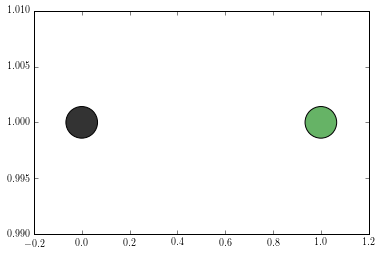

In [45]:
plt.scatter([0,1], [1,1], c = [gray_color, green_color], s = 1000)
plt.ylim(.99, 1.01)
plt.show()

# File reformatting
Files have to be formatted properly for Pandas to read them.
Convert these blocks to code to use (click cell, hit esc+y).
- Convert all field separators (delimiters) to the same type.
- Strip quotation marks.
- Save the file.
Only run these code blocks once

### Convert all delimiters to tab
Might have to edit the code to work for different formats of data files (all have been slightly different)

# Open data from files

##### Orbital periods:
- J1311: 93.8 minutes = 0.06514 days

In [33]:
directory = './data/J1311_5min/'
pulsar_name = 'J1311'
orbital_period = 0.06514

# > 2 GeV photons only
twogev_file_name = 'new_J1311_lc_2GeV.txt'
twogev_file_path = directory + twogev_file_name

# All photons
full_file_name = 'new_J1311_lc.txt'
full_file_path = directory + full_file_name

### Create pandas dataframe to contain all of the data

In [13]:
twogev_df = pd.read_csv(twogev_file_path, sep = '\t', header = 0)
full_df = pd.read_csv(full_file_path, sep = '\t', header = 0)

In [14]:
twogev_df.head(10)

,TIME,TIMEDEL,COUNTS,ERROR,EXPOSURE,RATE,RATE_ERROR
0,239557567.0,300.0,0,1.866025,0.0,NaN,NaN
1,239557867.0,300.0,0,1.866025,0.0,NaN,NaN
2,239558167.0,300.0,0,1.866025,0.0,NaN,NaN
3,239558467.0,300.0,0,1.866025,0.0,NaN,NaN
4,239558767.0,300.0,0,1.866025,0.0,NaN,NaN
5,239559067.0,300.0,0,1.866025,0.0,NaN,NaN
6,239559367.0,300.0,0,1.866025,0.0,NaN,NaN
7,239559667.0,300.0,0,1.866025,863776.6,0.0,0.000002
8,239559967.0,300.0,0,1.866025,509511.2,0.0,0.000004
9,239560267.0,300.0,0,1.866025,33179.0,0.0,0.000056


In [15]:
full_df.head(10)

,TIME,TIMEDEL,COUNTS,ERROR,EXPOSURE,RATE,RATE_ERROR
0,239557867.0,300.0,0,1.866025,0.000,NaN,NaN
1,239558167.0,300.0,0,1.866025,0.000,NaN,NaN
2,239558467.0,300.0,0,1.866025,0.000,NaN,NaN
3,239558767.0,300.0,0,1.866025,0.000,NaN,NaN
4,239559067.0,300.0,0,1.866025,0.000,NaN,NaN
5,239559367.0,300.0,0,1.866025,0.000,NaN,NaN
6,239559667.0,300.0,0,1.866025,157588.600,0.0,0.000012
7,239559967.0,300.0,0,1.866025,79693.590,0.0,0.000023
8,239560267.0,300.0,0,1.866025,4198.091,0.0,0.000444
9,239560567.0,300.0,0,1.866025,0.000,NaN,NaN


### Put the 'TIME' and 'RATE' columns into a numpy array
##### Do not include data points for which EXPOSURE = 0

In [16]:
twogev_data = twogev_df[(twogev_df['EXPOSURE'] != 0)][['TIME', 'RATE']].values
full_data = full_df[(full_df['EXPOSURE'] != 0)][['TIME', 'RATE']].values

##### - Convert seconds to days (because we expect to find periodicity in days)
##### - Offset to $t_{0} = 0$

In [18]:
for data in [twogev_data, full_data]:
    data[:,0] = (data[:,0] - full_data[0,0])/(24*60*60.0)

# Plot the rate time-series

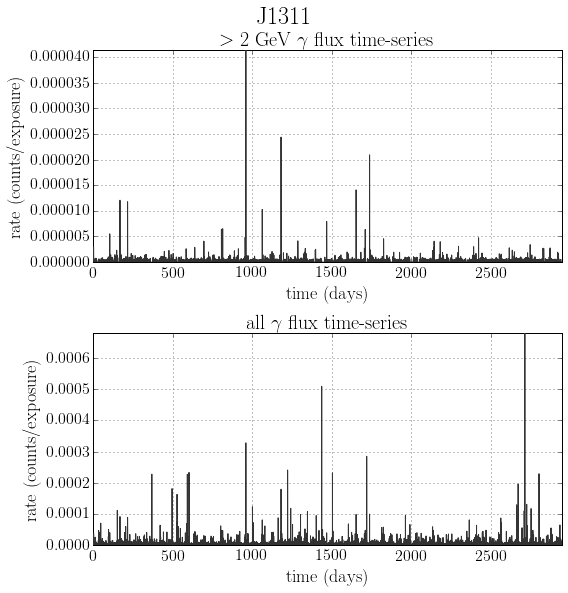

In [19]:
# Fig initialization
fig = plt.figure(figsize = (8,8))
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

plt.suptitle(pulsar_name, size = suptitle_size,  y = 1.025)

# > 2 GeV plot
plt.sca(ax0)
plt.plot(twogev_data[:,0], twogev_data[:,1], zorder = 100, c = gray_color) # zorder set large so data appears over grid

plt.xlim(np.min(twogev_data[:,0]), np.max(twogev_data[:,0]))
plt.ylim(0, np.max(twogev_data[:,1]))

plt.grid()
plt.tick_params(labelsize = axistick_size)

plt.title(r'$>2$ GeV $\gamma$ flux time-series', size = title_size)
plt.xlabel('time (days)', size = axislabel_size)
plt.ylabel('rate (counts/exposure)', size = axislabel_size)

# All photons plot
plt.sca(ax1)
plt.plot(full_data[:,0], full_data[:,1], zorder = 100, c = gray_color)

plt.xlim(np.min(full_data[:,0]), np.max(full_data[:,0]))
plt.ylim(0,np.max(twogev_data[:,1]))

plt.grid()
plt.tick_params(labelsize = axistick_size)

plt.title(r'all $\gamma$ flux time-series', size = title_size)
plt.xlabel('time (days)', size = axislabel_size)
plt.ylabel('rate (counts/exposure)', size = axislabel_size)

# Finalize, save, display plot
fig.tight_layout()
#plt.savefig('./' + pulsar_name + '_time-series.png', dpi = 300)

plt.show()

# Power spectral density (Lomb-Scargle periodogram)

- [PSD](https://en.wikipedia.org/wiki/Spectral_density) is the Fourier transform of the time-series, squared:
$$ S\left(f\right)=\|\hat{x}\left(f\right)\|^{2} = \left[\int_{-\infty}^{\infty}e^{-2\pi i f t}x\left(t\right)dt\right]^{2}$$
- It tells us how much of the total energy $~x^{2}$ is due to signal components at a given frequency
- If there's some strong underlying physical process with a well-defined period, it will appear as a peak in the PSD
- For discretely sampled data, we approximate the PSD with something called a **periodogram**
- If the data is *evenly sampled*, we simply replace the Fourier transform with a discrete Fourier transform
- The formula for the periodogram can be adapted for data that is not evenly sampled using something called the Lomb-Scargle periodogram
- There is a fast Lomb-Scargle implementation in the Python astropy package that we can use

In [22]:
from astropy.stats import LombScargle

##### Single segment Lomb-Scargle

In [48]:
num_intervals = 1.
twogev_sample_length = twogev_data.shape[0]/num_intervals
full_sample_length = full_data.shape[0]/num_intervals

twogev_frequency_list = []
twogev_power_list = []


seg_start = int(0)
seg_stop = int(twogev_sample_length)

twogev_frequency, twogev_power = astropy.stats.LombScargle(twogev_data[seg_start:seg_stop, 0],\
                                                       twogev_data[seg_start:seg_stop, 1]).autopower()

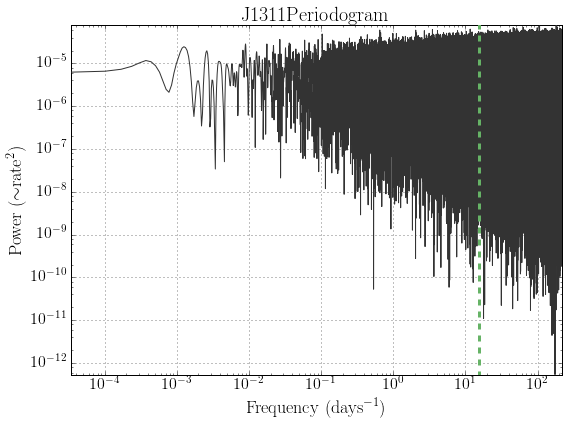

In [49]:
fig = plt.figure(figsize = (8,6))

plt.loglog(twogev_frequency, twogev_power, zorder = 100, c = gray_color)

# Plot a line through the expected orbital frequency
plt.plot([1./orbital_period, 1./orbital_period], [10.**(-32), 10.**32], ls = '--', lw = 3, c = green_color, zorder = 101)

plt.xlim(np.min(twogev_frequency), np.max(twogev_frequency))
plt.ylim(np.min(twogev_power), np.max(twogev_power))

plt.grid()

plt.title(pulsar_name + 'Periodogram', size = title_size)
plt.xlabel('Frequency (days$^{-1}$)', size = axislabel_size)
plt.ylabel('Power ($\sim$rate$^{2}$)', size = axislabel_size)
plt.tick_params(labelsize = axistick_size)

plt.tight_layout()

plt.show()

# Insert Welch's method for Lomb-Scargle